,Tanggal,qty,Jumlah
Tanggal,,,
2016-01-01,2016-01-01,8694,63467076.0
2016-01-02,2016-01-02,10044,73320032.0
2016-01-03,2016-01-03,13928,101671188.0
2016-01-04,2016-01-04,12518,91382972.0
2016-01-05,2016-01-05,11112,77424375.0
...,...,...,...
2021-10-25,2021-10-25,12239,93628350.0
2021-10-26,2021-10-26,11319,86590350.0
2021-10-27,2021-10-27,12502,95640300.0


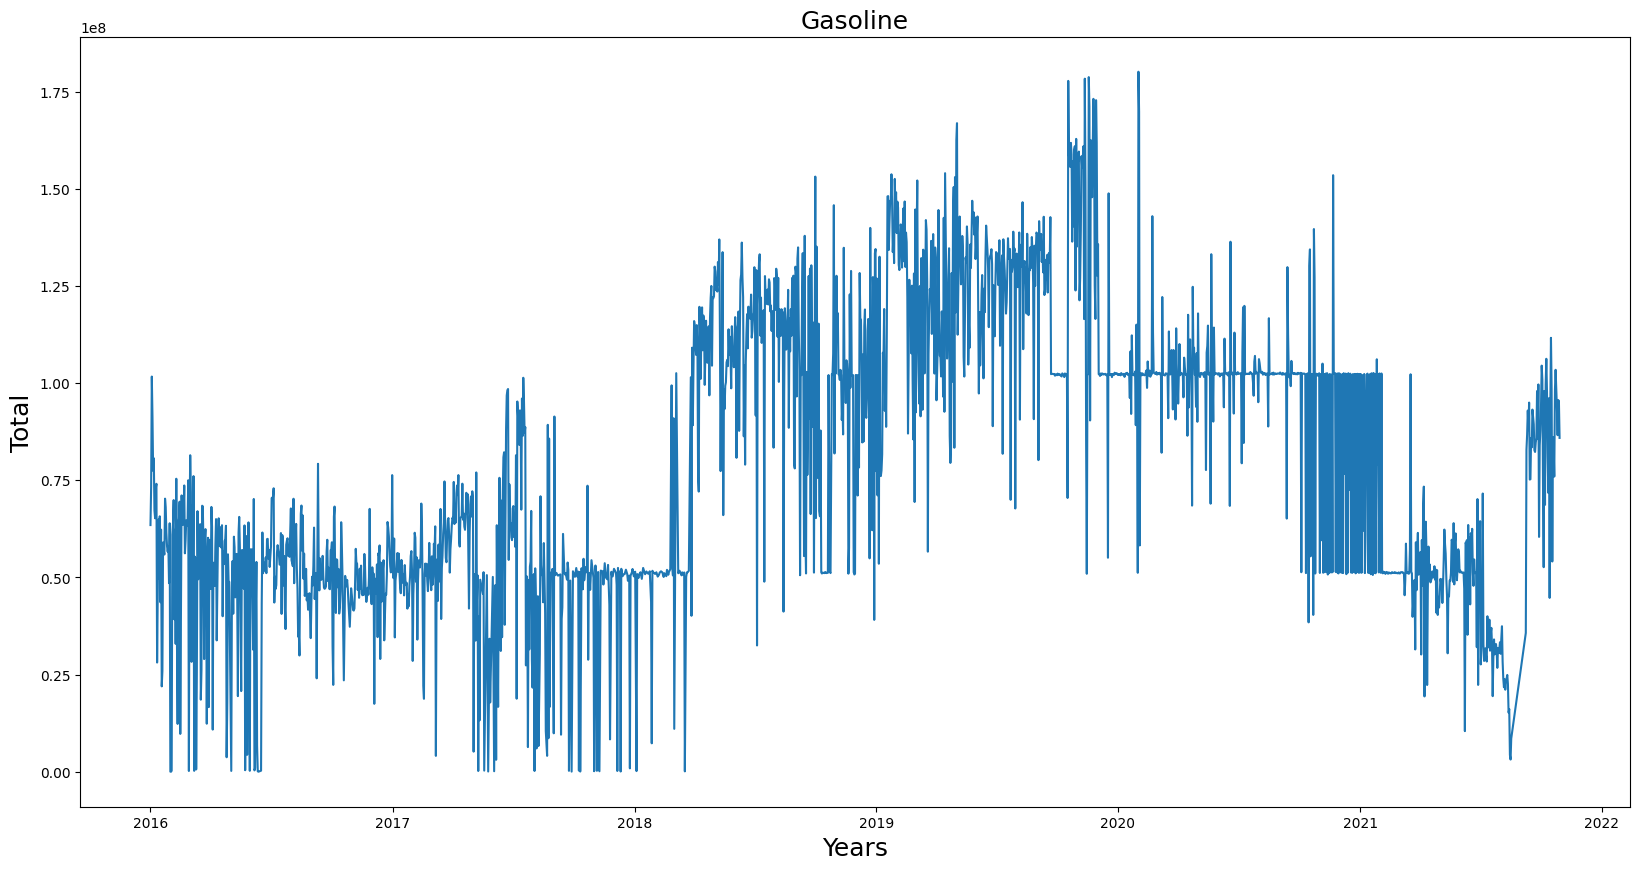

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =20,10

# Load dataset
df = pd.read_csv('Gasoline.csv')

# Set Tanggal as datetime index
df['Tanggal'] = pd.to_datetime(df.Tanggal, format='%Y-%m-%d')
df.index = df['Tanggal']

# Plot dataset
plt.figure(figsize=(20, 10))
plt.plot(df['Jumlah'], label='History Harga Penutup')
plt.title('Gasoline', fontsize=18)
plt.ylabel('Total', fontsize=18)
plt.xlabel('Years', fontsize=18)

df

In [29]:
# normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0, len(df)), columns=['Tanggal', 'Jumlah'])
for i in range(0, len(df)):
    new_data['Tanggal'][i] = data['Tanggal'][i]
    new_data['Jumlah'][i] = data['Jumlah'][i]

new_data.index = new_data['Tanggal']
new_data.drop('Tanggal', axis=1, inplace=True)

dataset = new_data.values

# Train-test split
train, valid = train_test_split(dataset, test_size=0.2, shuffle=False, random_state=0)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Prepare data for training
x_train, y_train = [], []
for i in range(60, len(train)):
    x_train.append(scaled_data[i - 60:i, 0])
    y_train.append(scaled_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(x_train)

/tmp/ipykernel_87257/274836543.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_data['Tanggal'][i] = data['Tanggal'][i]
/tmp/ipykernel_87257/274836543.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_data['Jumlah'][i] = data['Jumlah'][i]


[[[0.35237041]
  [0.40708254]
  [0.56451266]
  ...
  [0.41636229]
  [0.00106129]
  [0.36089651]]

 [[0.40708254]
  [0.56451266]
  [0.5073836 ]
  ...
  [0.00106129]
  [0.36089651]
  [0.45212047]]

 [[0.56451266]
  [0.5073836 ]
  [0.4298734 ]
  ...
  [0.36089651]
  [0.45212047]
  [0.39878692]]

 ...

 [[0.56888311]
  [0.56927709]
  [0.56838169]
  ...
  [0.56881148]
  [0.56909801]
  [0.56881148]]

 [[0.56927709]
  [0.56838169]
  [0.44062611]
  ...
  [0.56909801]
  [0.56881148]
  [0.56838169]]

 [[0.56838169]
  [0.44062611]
  [0.59950577]
  ...
  [0.56881148]
  [0.56838169]
  [0.57035157]]]


In [30]:
import time
mulai = time.time()
# Define the number of epochs to experiment with
epochs_list = [1]

# Run experiments
for epochs in epochs_list:
    print(f"\nTraining with {epochs} epochs...\n")

# Build LSTM model
model = Sequential()
model.add(LSTM(units=60, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=60))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=epochs, batch_size=5, verbose=1, validation_data=(x_train, y_train))

akhir = time.time()
waktu_detik = akhir - mulai
waktu_menit = "{:.2f}".format(waktu_detik / 60)





Training with 1 epochs...

308/308 [==============================] - 17s 46ms/step - loss: 0.0184 - val_loss: 0.0112
Run time for 1 epochs: 0.30 min


In [31]:
# Prepare data for testing
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

x_test = []
for i in range(60, inputs.shape[0]):
    x_test.append(inputs[i - 60:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [34]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# ...

# Predictions
closing_price_30 = []
closing_price_60 = []
closing_price_180 = []
closing_price_365 = []

for i in range(30):
    next_day_prediction = model.predict(x_test)
    closing_price_30.append(next_day_prediction[0, 0])
    x_test = np.roll(x_test, -1)
    x_test[-1, -1] = next_day_prediction[0, 0]

for i in range(30, 60):
    next_day_prediction = model.predict(x_test)
    closing_price_60.append(next_day_prediction[0, 0])
    x_test = np.roll(x_test, -1)
    x_test[-1, -1] = next_day_prediction[0, 0]

for i in range(60, 180):
    next_day_prediction = model.predict(x_test)
    closing_price_180.append(next_day_prediction[0, 0])
    x_test = np.roll(x_test, -1)
    x_test[-1, -1] = next_day_prediction[0, 0]

for i in range(180, 365):
    next_day_prediction = model.predict(x_test)
    closing_price_365.append(next_day_prediction[0, 0])
    x_test = np.roll(x_test, -1)
    x_test[-1, -1] = next_day_prediction[0, 0]

# Inverse transform to get the denormalized values
closing_price_30 = scaler.inverse_transform(np.array(closing_price_30).reshape(-1, 1))
closing_price_60 = scaler.inverse_transform(np.array(closing_price_60).reshape(-1, 1))
closing_price_180 = scaler.inverse_transform(np.array(closing_price_180).reshape(-1, 1))
closing_price_365 = scaler.inverse_transform(np.array(closing_price_365).reshape(-1, 1))

# Evaluate RMSE and MAPE
y_true = new_data['Jumlah'][-len(valid):].values

rmse_30 = sqrt(mean_squared_error(y_true[:30], closing_price_30))
mape_30 = np.mean(np.abs((y_true[:30] - closing_price_30.flatten()) / y_true[:30])) * 100

rmse_60 = sqrt(mean_squared_error(y_true[30:60], closing_price_60))
mape_60 = np.mean(np.abs((y_true[30:60] - closing_price_60.flatten()) / y_true[30:60])) * 100

rmse_180 = sqrt(mean_squared_error(y_true[60:180], closing_price_180))
mape_180 = np.mean(np.abs((y_true[60:180] - closing_price_180.flatten()) / y_true[60:180])) * 100

rmse_365 = sqrt(mean_squared_error(y_true[180:365], closing_price_365))
mape_365 = np.mean(np.abs((y_true[180:365] - closing_price_365.flatten()) / y_true[180:365])) * 100

# # Print RMSE and MAPE
# print(f"RMSE for 30 days: {rmse_30:.2f}")
# print(f"MAPE for 30 days: {mape_30:.2f}%")

# print(f"RMSE for 60 days: {rmse_60:.2f}")
# print(f"MAPE for 60 days: {mape_60:.2f}%")

# print(f"RMSE for 180 days: {rmse_180:.2f}")
# print(f"MAPE for 180 days: {mape_180:.2f}%")

# print(f"RMSE for 365 days: {rmse_365:.2f}")
# print(f"MAPE for 365 days: {mape_365:.2f}")


13/13 [==============================] - 0s 12ms/step


13/13 [==============================] - 0s 12ms/step


13/13 [==============================] - 0s 12ms/step


/tmp/ipykernel_87257/1879727800.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


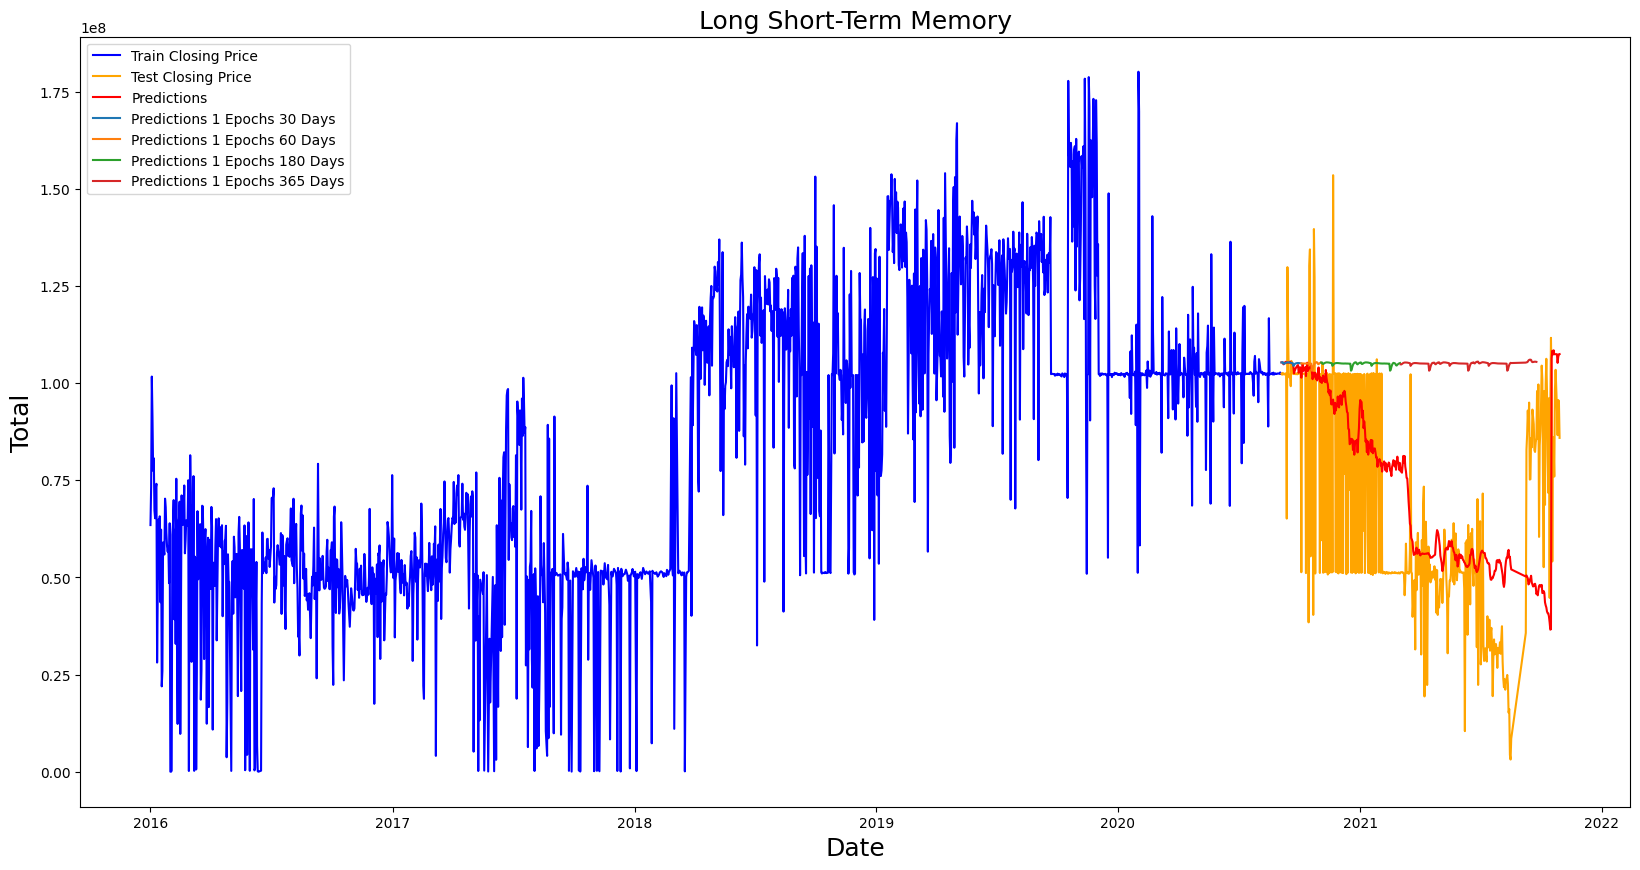

In [36]:
# Split data into train and valid
train_size = int(len(new_data) * 0.8)
train, valid = new_data[:train_size], new_data[train_size:]

# Plot training and validation data
valid['Predictions'] = closing_price
plt.title('Long Short-Term Memory', fontsize=18)
plt.plot(train['Jumlah'], label='Train Closing Price', color='blue')
plt.plot(valid['Jumlah'], label='Test Closing Price', color='orange')
plt.plot(valid['Predictions'], label='Predictions',color='red')

# Plot prediction
plt.plot(valid.index[:30], closing_price_30, label=f'Predictions {epochs} Epochs 30 Days')
plt.plot(valid.index[30:60], closing_price_60, label=f'Predictions {epochs} Epochs 60 Days')
plt.plot(valid.index[60:180], closing_price_180, label=f'Predictions {epochs} Epochs 180 Days')
plt.plot(valid.index[180:365], closing_price_365, label=f'Predictions {epochs} Epochs 365 Days')

plt.legend(loc="upper left")
plt.xlabel('Date', fontsize=18)
plt.ylabel('Total', fontsize=18)
plt.show()


RMSE (30 Days): 9109074.40
MAPE (30 Days): 5.33%
RMSE (60 Days): 29412157.51
MAPE (60 Days): 32.47%
RMSE (180 Days): 39840375.95
MAPE (180 Days): 58.73%
RMSE (365 Days): 59439155.77
MAPE (365 Days): 181.80%


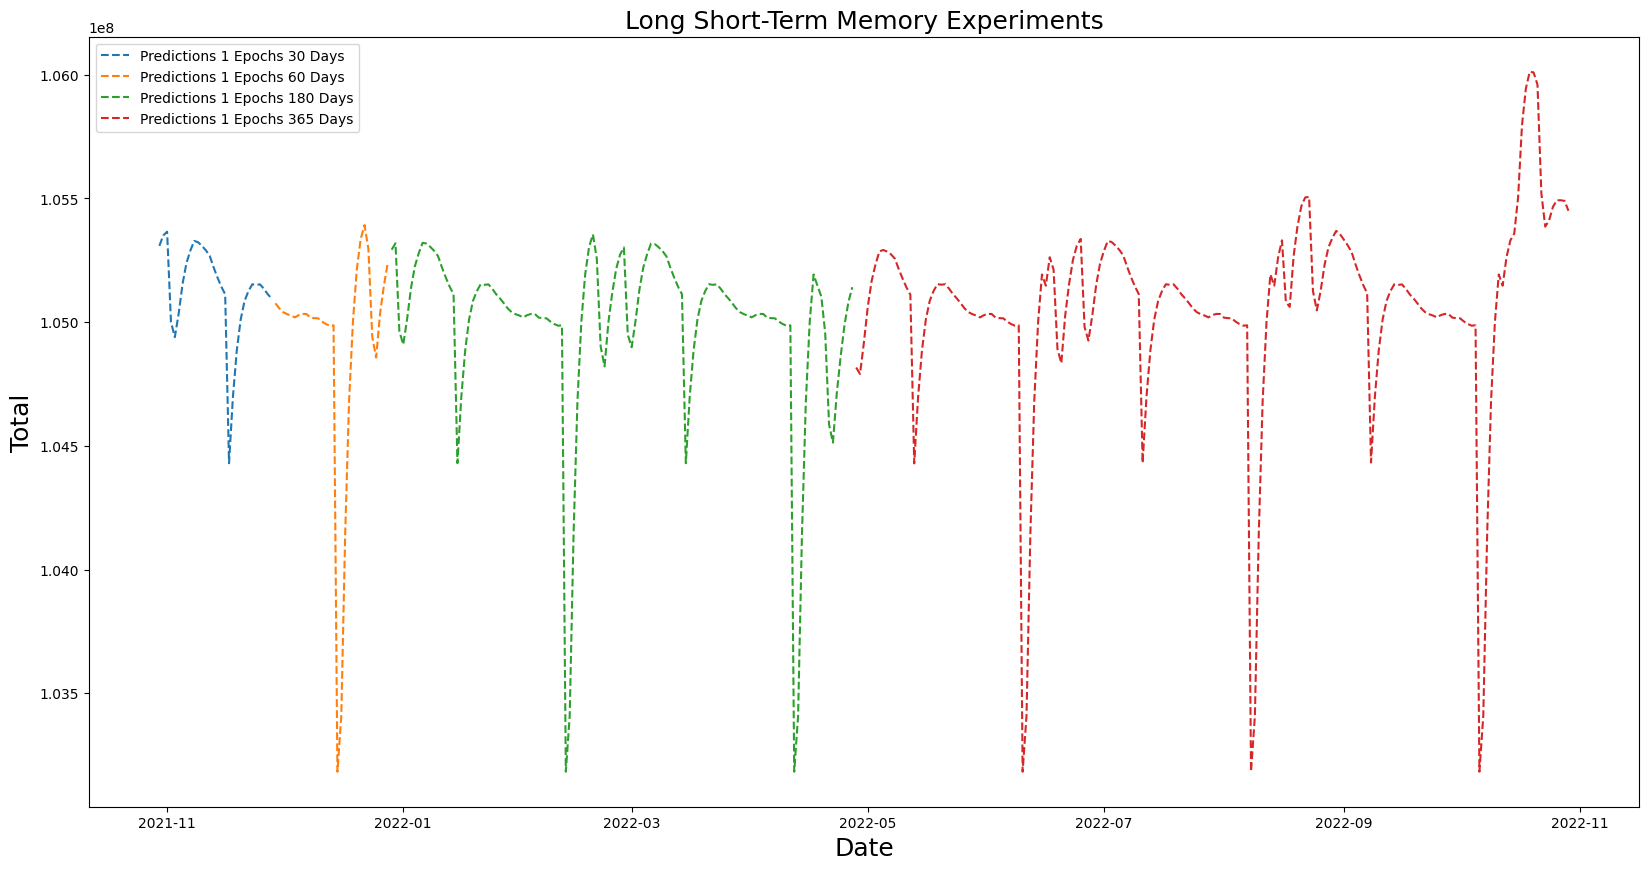

In [39]:
print(f'RMSE (30 Days): {rmse_30:.2f}')
print(f'MAPE (30 Days): {mape_30:.2f}%')
print(f'RMSE (60 Days): {rmse_60:.2f}')
print(f'MAPE (60 Days): {mape_60:.2f}%')
print(f'RMSE (180 Days): {rmse_180:.2f}')
print(f'MAPE (180 Days): {mape_180:.2f}%')
print(f'RMSE (365 Days): {rmse_365:.2f}')
print(f'MAPE (365 Days): {mape_365:.2f}%')
# # Plot predictions
# plt.plot(range(len(valid), len(valid) + 30), closing_price_30, label=f'Predictions {epochs} Epochs 30 Days', linestyle='--')
# plt.plot(range(len(valid) + 30, len(valid) + 60), closing_price_60, label=f'Predictions {epochs} Epochs 60 Days', linestyle='--')
# plt.plot(range(len(valid) + 60, len(valid) + 180), closing_price_180, label=f'Predictions {epochs} Epochs 180 Days', linestyle='--')
# plt.plot(range(len(valid) + 180, len(valid) + 365), closing_price_365, label=f'Predictions {epochs} Epochs 365 Days', linestyle='--')


# # Plot legends and show the plot
# plt.legend(loc="upper left")
# plt.title('Long Short-Term Memory Experiments', fontsize=18)
# plt.xlabel('Date', fontsize=18)
# plt.ylabel('Total', fontsize=18)
# plt.gcf().set_size_inches(20, 10)  # Increase plot size
# plt.show()

# Plot predictions for 30 days
closing_price_30_index = pd.date_range(start=valid.index[-1] + pd.Timedelta(days=1), periods=30)
plt.plot(closing_price_30_index, closing_price_30, label=f'Predictions {epochs} Epochs 30 Days', linestyle='--')

# Plot predictions for 60 days
closing_price_60_index = pd.date_range(start=valid.index[-1] + pd.Timedelta(days=31), periods=30)
plt.plot(closing_price_60_index, closing_price_60, label=f'Predictions {epochs} Epochs 60 Days', linestyle='--')

# Plot predictions for 180 days
closing_price_180_index = pd.date_range(start=valid.index[-1] + pd.Timedelta(days=61), periods=120)
plt.plot(closing_price_180_index, closing_price_180, label=f'Predictions {epochs} Epochs 180 Days', linestyle='--')

# Plot predictions for 365 days
closing_price_365_index = pd.date_range(start=valid.index[-1] + pd.Timedelta(days=181), periods=185)
plt.plot(closing_price_365_index, closing_price_365, label=f'Predictions {epochs} Epochs 365 Days', linestyle='--')

# Plot legends and show the plot
plt.legend(loc="upper left")
plt.title('Long Short-Term Memory Experiments', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Total', fontsize=18)
plt.gcf().set_size_inches(20, 10)  # Increase plot size
plt.show()

print(f"Run time for {epochs} epochs: {waktu_menit} min")